In [1]:
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import match_template
from skimage.feature import peak_local_max
from skimage.io import imsave, imread

import imageio as iio

from typing import Tuple

In [2]:
# foam template:
# filename: tg_post_light_001.mp4
# frame: 200
# [180:220, 1100:1130]

## Custom written functions:

#### Foam detection:

In [3]:
def get_boundaries(array, start_index, half_window_size=5, tolerance_factor=10):
    start_mean = array[start_index-half_window_size:start_index+half_window_size].mean()
    tolerance = array[start_index-half_window_size:start_index+half_window_size].std()*tolerance_factor
    if tolerance < 0.05:
        tolerance = 0.05
    
    # get upper boundary:
    for pixel_idx in range(start_index, array.shape[0]-half_window_size):
        window_mean = array[pixel_idx-half_window_size:pixel_idx+half_window_size].mean()
        if start_mean - window_mean > tolerance:
                break
    max_idx = pixel_idx + half_window_size
    
    # get lower boundary:
    for pixel_idx in range(start_index):
        window_mean = array[start_index-pixel_idx-half_window_size:start_index-pixel_idx+half_window_size].mean()
        if start_mean - window_mean > tolerance:
                break
    min_idx = start_index - pixel_idx - half_window_size
    
    return min_idx, max_idx

def get_vial_cropping_info_from_foam_matching(image, foam_template):
    foam_results = match_template(image[0:500], foam_template)
    row_idx, col_idx = np.unravel_index(foam_results[...,0].argmax(), foam_results[...,0].shape)
    row = foam_results[...,0][row_idx]
    column = foam_results[...,0][:, col_idx]
    min_col_idx, max_col_idx = get_boundaries(row, col_idx)
    # Transform back to original image coordinates
    min_col_idx += int(foam_template.shape[1]/2)
    max_col_idx += int(foam_template.shape[1]/2)
    return min_col_idx, max_col_idx

#### Preparing templates:

In [4]:
def get_arrays_from_center_coords(original_image: np.ndarray, coords_of_center: Tuple[int, int], height: int=40, width: int=30) -> np.ndarray:
    row_min = int(coords_of_center[0] - height/2)
    row_max = int(coords_of_center[0] + height/2)
    col_min = int(coords_of_center[1] - width/2)
    col_max = int(coords_of_center[1] + width/2)
    return original_image[row_min:row_max, col_min:col_max]

In [5]:
def save_fly_and_bkgr_templates(center_coords, root_dir_path, out_dir_fly_templates, out_dir_bkgr_templates, fly_count_start=1, bkgr_count_start=1):
    fly_count = fly_count_start
    bkgr_count = bkgr_count_start
    foam = imread('foam_templates/001_foam.png')
    for filename in center_coords.keys():
        if len(list(center_coords[filename].keys())) == 0:
            continue
        else: 
            frame_index = list(center_coords[filename].keys())[0]
            reader = iio.get_reader(root_dir_path + filename)
            img = reader.get_data(frame_index)
            reader.close()
            print(f'opened {filename}')
            min_col_idx, max_col_idx = get_vial_cropping_info_from_foam_matching(img, foam, 100)
            vial = img[200:1000, min_col_idx:max_col_idx]
            for fly_id in center_coords[filename][frame_index]['flies'].keys():
                fly_template = get_arrays_from_center_coords(vial, center_coords[filename][frame_index]['flies'][fly_id])
                imsave(f'{out_dir_fly_templates}fly_{str(fly_count).zfill(3)}.png', fly_template, check_contrast = False)
                fly_count += 1
            for bkgr_id in center_coords[filename][frame_index]['bkgrs'].keys():
                bkgr_template = get_arrays_from_center_coords(vial, center_coords[filename][frame_index]['bkgrs'][bkgr_id])
                imsave(f'{out_dir_bkgr_templates}bkgr_{str(bkgr_count).zfill(3)}.png', bkgr_template, check_contrast = False)
                bkgr_count += 1    

In [6]:
def plot_all_templates(template_dir, plots_per_row, save=False, show=True):
    files = os.listdir(template_dir)
    n_files = len(files)
    if n_files % plots_per_row == 0:
        rows = int(n_files / plots_per_row)
    else: 
        rows = int(n_files / plots_per_row) + 1
    
    fig, axs = plt.subplots(rows, plots_per_row, figsize=(20, 20), facecolor='white')
    
    row_idx, col_idx = 0, 0
    for index in range(n_files):
        if (index > 0) & (index % plots_per_row == 0):
            row_idx += 1
            col_idx = 0
        template = imread(template_dir + files[index])
        axs[row_idx, col_idx].imshow(template)
        col_idx += 1
    
    if save:
        template_type = template_dir[:template_dir.find('_')]
        plt.tight_layout()
        plt.savefig(f'all_{template_type}_templates.png')
    
    if show:    
        plt.show()
    else:
        plt.close()
        
# filename: tg_post_light_001.mp4
# frame: 200
# [180:220, 1100:1130]

In [7]:
def list_no_hidden(filepath):
    return [elem for elem in os.listdir(filepath) if elem.startswith('.') == False]

In [18]:
'0001_hund'[:4]

'0001'

In [8]:
def detect_flies(video_file_path, frame_index, fly_template_dir, bkgr_template_dir, foam, threshold=0.25, min_climbing_height=600, plot=False):
    reader = iio.get_reader(video_file_path)
    img = reader.get_data(frame_index)
    reader.close()
    
    #Change - then we can use these col indices right away to filter potentially detectes flies on left and right border
    cropping_buffer_zone = 100
    min_col_idx, max_col_idx = get_vial_cropping_info_from_foam_matching(img, foam)
    vial = img[200:1000, min_col_idx-cropping_buffer_zone:max_col_idx+cropping_buffer_zone]

    flies = list()
    for filename in list_no_hidden(fly_template_dir):
        flies.append(imread(fly_template_dir + filename))
    bkgrs = list()
    for filename in list_no_hidden(bkgr_template_dir):
        bkgrs.append(imread(bkgr_template_dir + filename))
    
    template_matching_results = {'flies': list(),
                                 'bkgrs': list()}
    for fly in flies:
        template_matching_results['flies'].append(match_template(vial, fly)) 
    for bkgr in bkgrs:
        template_matching_results['bkgrs'].append(match_template(vial, bkgr)) 
    fly_mean_results = sum(template_matching_results['flies']) / len(template_matching_results['flies'])
    bkgr_mean_results = sum(template_matching_results['bkgrs']) / len(template_matching_results['bkgrs'])
    bkgr_corrected_results = fly_mean_results - bkgr_mean_results
    
    flies_xy = peak_local_max(bkgr_corrected_results[..., 0], min_distance=25,threshold_abs=threshold)
    corrected_fly_coords = flies_xy.copy()
    corrected_fly_coords[:,0] += 15
    corrected_fly_coords[:, 1] += 20

    if plot:
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
        ax1.imshow(bkgr_corrected_results[..., 0])
        ax1.scatter(flies_xy[:, 1], flies_xy[:, 0])
        ax2.imshow(vial)
        ax2.scatter(corrected_fly_coords[:, 1], corrected_fly_coords[:,0])
        ax2.vlines(x=[100, vial.shape[1]-100], ymin=0, ymax=vial.shape[0])
        ax3.imshow(vial)
        plt.show()
        
    min_climbing_height = min_climbing_height

    corrected_fly_coords_as_list = list(corrected_fly_coords)

    idx_to_pop = list()
    for fly_index in range(len(corrected_fly_coords_as_list)):
        if cropping_buffer_zone < corrected_fly_coords_as_list[fly_index][1] < vial.shape[1] - cropping_buffer_zone:
            if min_climbing_height > corrected_fly_coords_as_list[fly_index][0]:
                pass
            else: idx_to_pop.append(fly_index)
        else:
            idx_to_pop.append(fly_index)

    idx_to_pop.sort(reverse = True)
    for idx in idx_to_pop:
        corrected_fly_coords_as_list.pop(idx)
        
    return corrected_fly_coords_as_list

In [9]:
experiment_dir = '/home/pi/Desktop/2021_01_07_DS_ok6/'
files = list_no_hidden(experiment_dir)
files.sort()

In [10]:
filename = files[2]
frame_index = 100
foam = imread('foam_templates/001_foam.png')

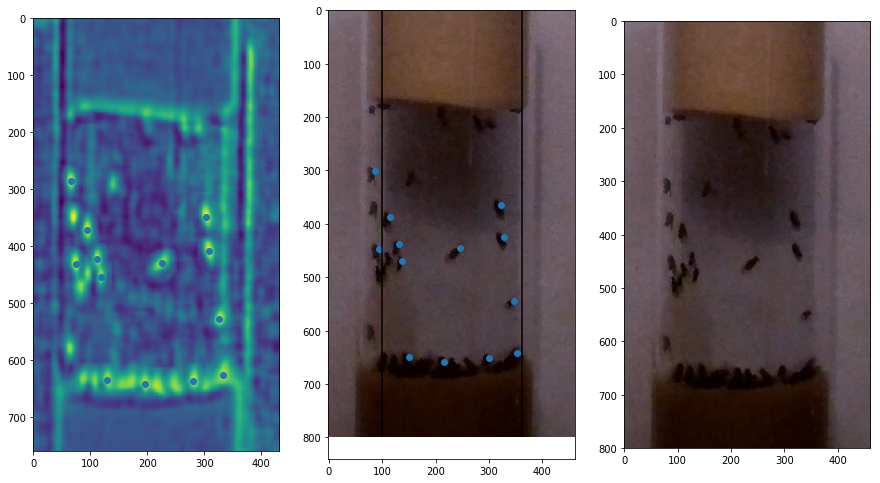

251.0480420589447

In [105]:
start = time.time()
corrected_fly_coords_as_list2 = detect_flies(video_file_path = experiment_dir + filename, 
                                             frame_index = frame_index, 
                                             fly_template_dir = 'fly_templates/subset/', 
                                             bkgr_template_dir = 'bkgr_templates/subset/', 
                                             foam = foam, threshold=0.2, min_climbing_height=600, plot=True)
end = time.time()

end - start

In [158]:
hunde = np.asarray(['hund', 'dog', 'delfin', 'hund'])
katzen = np.asarray(['cat', 'katze', 'katze'])

matches_hunde = np.where(hunde == 'hund')
matches_katzen = np.where(katzen == 'katze')
matches_vogel = np.where(np.asarray(['vogel', 'vogel', 'vogel']) == 'vogel')

exists = list()
for match_id in matches_hunde[0]:
    exists.append((match_id in matches_katzen[0]) & (match_id in matches_vogel[0]))


In [165]:
any([False, False, False])

False

In [143]:
match_id in matches_hunde

0

In [138]:
matches_hunde

[array([0, 2], dtype=int32)]

In [1]:
results_for_df

NameError: name 'results_for_df' is not defined

In [226]:
does_entry_already_exist(results_for_df, 'tg', 'post', '001', 5.0)

True

In [222]:
group_id = 'tg'
pre_post = 'post'
vial_id = '001'
time_passed = 5.0

group_id_matches = np.where(np.asarray(results_for_df['group_id']) == group_id)
pre_post_matches = np.where(np.asarray(results_for_df['pre_post']) == pre_post)
vial_id_matches = np.where(np.asarray(results_for_df['vial_id']) == vial_id)
time_passed_matches = np.where(np.asarray(results_for_df['time_passed']) == time_passed)
exists = list()
for match_index in group_id_matches[0]:
    exists.append((match_id in pre_post_matches[0]) & (match_id in vial_id_matches[0]) & (match_id in time_passed_matches[0]))
any(exists)

False

In [223]:
group_id_matches = np.where(np.asarray(results_for_df['group_id']) == group_id)
pre_post_matches = np.where(np.asarray(results_for_df['pre_post']) == pre_post)
vial_id_matches = np.where(np.asarray(results_for_df['vial_id']) == vial_id)
time_passed_matches = np.where(np.asarray(results_for_df['time_passed']) == time_passed)

In [224]:
exists = list()
for match_id in group_id_matches[0]:
    exists.append((match_id in pre_post_matches[0]) & (match_id in vial_id_matches[0]) & (match_id in time_passed_matches[0]))
any(exists)

True

In [208]:
4 in time_passed_matches[0]

True

In [225]:
def does_entry_already_exist(results_for_df, group_id, pre_post, vial_id, time_passed):
    group_id_matches = np.where(np.asarray(results_for_df['group_id']) == group_id)
    pre_post_matches = np.where(np.asarray(results_for_df['pre_post']) == pre_post)
    vial_id_matches = np.where(np.asarray(results_for_df['vial_id']) == vial_id)
    time_passed_matches = np.where(np.asarray(results_for_df['time_passed']) == time_passed)
    exists = list()
    for match_index in group_id_matches[0]:
        exists.append((match_index in pre_post_matches[0]) & (match_index in vial_id_matches[0]) & (match_index in time_passed_matches[0]))
    return any(exists)
    
    

In [172]:
def add_to_results_for_df(results_for_df, group_id, pre_post, vial_id, time_passed, n_flies):
    results_for_df['group_id'].append(group_id)
    results_for_df['pre_post'].append(pre_post)
    results_for_df['vial_id'].append(vial_id)
    results_for_df['time_passed'].append(time_passed)
    results_for_df['n_flies'].append(n_flies)
    
    
    

In [193]:
detected_flies

{'tg_post_light_001.mp4': {30: [array([485, 124], dtype=int32)],
  60: [array([486, 113], dtype=int32)],
  90: [array([490, 127], dtype=int32)],
  120: [array([503, 120], dtype=int32)],
  150: [array([506, 120], dtype=int32)]},
 'tg_post_light_002.mp4': {30: [array([460, 142], dtype=int32)],
  60: [array([454, 129], dtype=int32)],
  90: [array([465, 131], dtype=int32)],
  120: [array([454, 127], dtype=int32)],
  150: [array([451, 131], dtype=int32)]}}

In [257]:
files

['tg_post_light_001.mp4',
 'tg_post_light_002.mp4',
 'tg_pre_light_001.mp4',
 'tg_pre_light_002.mp4',
 'wt_post_light_001.mp4',
 'wt_post_light_002.mp4',
 'wt_pre_light_001.mp4',
 'wt_pre_light_002.mp4']

In [249]:
files[4:6]

['wt_post_light_001.mp4', 'wt_post_light_002.mp4']

In [ ]:
seconds_to_quantify = 5
#detected_flies = dict()

In [14]:

for filename in files[4:6]:
    print('\n')
    print(f'starting with file: {filename}')
    if filename in detected_flies.keys():
        print('These computations were already done! Please select a new filename.')
    else:
        detected_flies[filename] = dict()
        for x in range(seconds_to_quantify):
            frame_index = 30 + 30 * x
            print(f'... starting with the analysis of frame #{frame_index} - {x+1}/{seconds_to_quantify}')
            start = time.time()
            detected_flies[filename][frame_index] = detect_flies(video_file_path = experiment_dir + filename, 
                                                                 frame_index = frame_index, 
                                                                 fly_template_dir = 'fly_templates/subset/', 
                                                                 bkgr_template_dir = 'bkgr_templates/subset/', 
                                                                 foam = foam, threshold=0.25, min_climbing_height=600, plot=False)
            end = time.time()
            print(f'... took me {end - start} seconds to detect {len(detected_flies[filename][frame_index])} flies :-)')






starting with file: wt_post_light_001.mp4


NameError: name 'detected_flies' is not defined

In [252]:
save_copy = results_for_df.copy()
save_copy

{'group_id': ['tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg'],
 'pre_post': ['post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre'],
 'vial_id': ['001',
  '001',
  '001',
  '001',
  '001',
  '002',
  '002',
  '002',
  '002',
  '002',
  '001',
  '001',
  '001',
  '001',
  '001',
  '002',
  '002',
  '002',
  '002',
  '002'],
 'time_passed': [1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0],
 'n_flies': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 6, 4, 5, 7, 7, 7, 7, 8, 8]}

In [254]:
results_for_df

{'group_id': ['tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'wt',
  'wt',
  'wt',
  'wt',
  'wt',
  'wt',
  'wt',
  'wt',
  'wt',
  'wt'],
 'pre_post': ['post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post'],
 'vial_id': ['001',
  '001',
  '001',
  '001',
  '001',
  '002',
  '002',
  '002',
  '002',
  '002',
  '001',
  '001',
  '001',
  '001',
  '001',
  '002',
  '002',
  '002',
  '002',
  '002',
  '001',
  '001',
  '001',
  '001',
  '001',
  '002',
  '002',
  '002',
  '002',
  '002'],
 'time_passed': [1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,


In [50]:
fname = '0000_tg_post_light_001.mp4'

fname[8:fname.find('_light')]

'post'

In [40]:
file_id = fname[:4]
vial_id = fname[fname.rfind('_') + 1 : fname.find('.mp4')]
group_id = fname[5:fname[5:].find('_') + 5]
pre_post = fname[fname[5:].find('_') + 4 + len(group_id): fname.find('_light')]

In [58]:
a = [None, None]

indices = [i for i in range(len(a)) if a[i] == None]

In [59]:
indices

[0, 1]

In [53]:
fname[fname[5:].find('_') + 4 + len(group_id): fname.find('_light')]

'post'

In [46]:
len(group_id)

2

In [42]:
fname[fname.find(group_id):].find('_')

2

In [253]:
try:
    if type(results_for_df) == dict:
        pass
        

except NameError:
    results_for_df = {'group_id': list(),
                      'pre_post': list(),
                      'vial_id': list(),
                      'time_passed': list(),
                      'n_flies': list()}
    
finally:
    for filename in detected_flies.keys():
        group_id = filename[:filename.find('_')]
        pre_post = filename[filename.find('_')+1:filename.find('_light')]
        vial_id = filename[filename.find('.mp4')-3:filename.find('.mp4')]
        for frame_index in detected_flies[filename].keys():
            time_passed = frame_index / 30
            n_flies = len(detected_flies[filename][frame_index])
            entry_existis_already = does_entry_already_exist(results_for_df=results_for_df, 
                                                             group_id=group_id, 
                                                             pre_post=pre_post, 
                                                             vial_id=vial_id, 
                                                             time_passed=time_passed)
            if entry_existis_already == False:
                add_to_results_for_df(results_for_df=results_for_df, 
                                      group_id=group_id, 
                                      pre_post=pre_post, 
                                      vial_id=vial_id, 
                                      time_passed=time_passed, 
                                      n_flies=n_flies)

In [11]:
import pickle


In [12]:
with open('results_for_df.p', 'rb') as io:
    results_for_df = pickle.load(io)

In [13]:
import pandas as pd

df = pd.DataFrame(data=results_for_df)

df

,group_id,pre_post,vial_id,time_passed,n_flies
0,tg,post,001,1.0,1
1,tg,post,001,2.0,1
2,tg,post,001,3.0,1
3,tg,post,001,4.0,1
4,tg,post,001,5.0,1
5,tg,post,002,1.0,1
6,tg,post,002,2.0,1
7,tg,post,002,3.0,1
8,tg,post,002,4.0,1
9,tg,post,002,5.0,1


In [4]:
results_for_df

{'group_id': ['tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg',
  'tg'],
 'pre_post': ['post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'post',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre',
  'pre'],
 'vial_id': ['001',
  '001',
  '001',
  '001',
  '001',
  '002',
  '002',
  '002',
  '002',
  '002',
  '001',
  '001',
  '001',
  '001',
  '001',
  '002',
  '002',
  '002',
  '002',
  '002'],
 'time_passed': [1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0],
 'n_flies': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 6, 4, 5, 7, 7, 7, 7, 8, 8]}

In [247]:
with open('results_for_df.p', 'wb') as io:
    pickle.dump(results_for_df, io)

In [ ]:
timepoints

summarize across files

stats & plot

In [19]:
flies_xyab = np.asarray([[100, 100],
                      [120, 200],
                      [82, 199]])

flies_xyab.shape

(3, 2)

In [94]:
min_climbing_height = 600

corrected = flies_xy.copy()

corrected[:,0] += 15
corrected[:, 1] += 20
flies_row_col_as_list = list(corrected)

idx_to_pop = list()
for fly_index in range(len(flies_row_col_as_list)):
    if cropping_buffer_zone < flies_row_col_as_list[fly_index][1] < vial.shape[1] - cropping_buffer_zone:
        if min_climbing_height > flies_row_col_as_list[fly_index][0]:
            pass
        else: idx_to_pop.append(fly_index)
    else:
        idx_to_pop.append(fly_index)

idx_to_pop.sort(reverse = True)
for idx in idx_to_pop:
    flies_row_col_as_list.pop(idx)

In [95]:
flies_row_col_as_list

[array([571, 110], dtype=int32),
 array([507, 279], dtype=int32),
 array([450, 342], dtype=int32)]

In [82]:
cropping_buffer_zone = 100

In [43]:
vial.shape[1] - 100

353

In [39]:
min_col_idx

1029

In [40]:
max_col_idx

1282

In [86]:
idx_to_pop

[8, 7, 6]

In [88]:
flies_row_col_as_list

[array([684, 291], dtype=int32),
 array([660, 195], dtype=int32),
 array([613, 347], dtype=int32),
 array([571, 110], dtype=int32),
 array([507, 279], dtype=int32),
 array([450, 342], dtype=int32)]